# Weighted Fusion of Audio and Text Models

Performing weighted fusion of predictions from both audio and text models.
___
Abhay Jolly | ajolly@sfu.ca\
Harry Preet Singh | hps1@sfu.ca\
Karan Pathania | kpathani@sfu.ca\
Neil Mukesh Shah | nmshah@sfu.ca
___
CMPT 419, Spring 2022\
Simon Fraser University

# 0. Preprocessing

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Ensure tensorflow version 2.x
%tensorflow_version 2.x

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Set directories
PROJECT_DIR = '/content/drive/MyDrive/CMPT 419 Project'
AUDIO_DIR = os.path.join(PROJECT_DIR, 'audio_dataset')
TEXT_DIR = os.path.join(PROJECT_DIR, 'text_dataset')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Function to print classification report and confusion matrix
def print_cr_cm(y_true, y_pred, labels=None):
  print('-' * 25, '\nClassification Report\n', '-' * 25, sep = '')
  print(classification_report(y_true, y_pred))

  print('-' * 25, '\nConfusion Matrix\n', '-' * 25, '\n', sep = '')
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
  plt.show()

# 1. Load Models & Data

In [ ]:
# Load all models
model_rnn = keras.models.load_model(os.path.join(PROJECT_DIR, 'Model_LSTM_RNN'))
model_cnn = keras.models.load_model(os.path.join(PROJECT_DIR, 'Model_CNN'))
model_rf = joblib.load(os.path.join(PROJECT_DIR, 'Model_RF', 'random_forest.joblib'))

## 1.1 Load testing dataset for audio (CNN)

In [ ]:
# Required constants
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
COLOR_MODE = 'rgb'
LABEL_MODE = 'int'
CLASS_NAMES = ['toxic', 'nontoxic']

# Make a dataset containing the testing spectrograms
test_dataset_cnn = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    directory=os.path.join(AUDIO_DIR, 'spectrogram_mel_split', 'test'),
    color_mode=COLOR_MODE,
    shuffle=False,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    seed=0)

file_paths = test_dataset_cnn.file_paths

# Save all the audio file names for later use
AUDIO_TEST_FILENAMES = [os.path.splitext(os.path.basename(f))[0] for f in file_paths]

cnn_df = pd.DataFrame(AUDIO_TEST_FILENAMES, columns=['Filename'])

Found 123 files belonging to 2 classes.


## 1.2 Load testing dataset for audio (RF)

In [ ]:
test_dataset_rf = pd.read_csv(os.path.join(AUDIO_DIR, 'audio_features_data', 'test_data.csv'))
rf_df = test_dataset_rf[['Filename', 'label']]
test_dataset_rf = test_dataset_rf.drop(columns=['Filename', 'label'])

## 1.3 Load testing dataset for text (LSTM-RNN)

In [ ]:
# Load testing text dataset
text_df = pd.read_csv(os.path.join(TEXT_DIR, 'test', 'compiled_data.csv'))
text_df = text_df[['Filename', 'Text', 'Label']]
text_df = text_df[text_df['Filename'].isin(AUDIO_TEST_FILENAMES)]
text_df = text_df.reset_index(drop=True)

# 2. Evaluation

## 2.1 Evaluate text using LSTM-RNN

In [ ]:
# Load tokenizer for text predictions
import pickle

with open(os.path.join(TEXT_DIR, 'train', 'tokenizer.pickle'), 'rb') as handle:
    tokenizer = pickle.load(handle)

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        63
           1       0.77      0.60      0.67        60

    accuracy                           0.72       123
   macro avg       0.73      0.71      0.71       123
weighted avg       0.72      0.72      0.71       123

-------------------------
Confusion Matrix
-------------------------



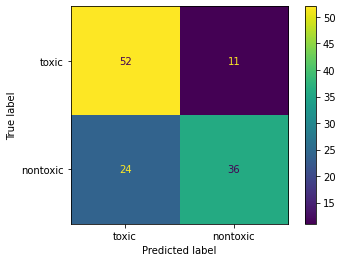

In [ ]:
MAX_PADLEN = 200

# Contains predicition probability of toxic class
predictions_rnn = []

y_true = text_df['Label'].values
y_pred = []

strings = text_df['Text'].values

# Predict text using LSTM-RNN
for s in strings:
    seq = tokenizer.texts_to_sequences([s])
    seq = pad_sequences(seq, maxlen=MAX_PADLEN, padding='post')
    pred = model_rnn.predict(seq)
    predictions_rnn.append(pred[0][np.argmax(pred[0])])

    if (predictions_rnn[-1] > 0.02):
        y_pred.append(1)
    else:
        y_pred.append(0)

# Print classification report and confusion matrix
print_cr_cm(y_true, y_pred, labels=CLASS_NAMES)

In [ ]:
text_df[["text_prediction_toxic"]] = pd.DataFrame(predictions_rnn)
text_df.head()

,Filename,Text,Label,text_prediction_toxic
0,1_00002,Why do hindus look smelly.,1,0.527486
1,1_00007,"Christians are subhumans with zero intellect, ...",1,0.230780
2,1_00008,A hindu believes a cow to be their mother if s...,1,0.507827
3,1_00009,I dont want to forge friendships with homos no...,1,0.008547
4,1_00012,So basically the Evangelicals are the taliban ...,1,0.023417


## 2.2 Evaluate audio using CNN

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        60
           1       0.91      0.94      0.92        63

    accuracy                           0.92       123
   macro avg       0.92      0.92      0.92       123
weighted avg       0.92      0.92      0.92       123

-------------------------
Confusion Matrix
-------------------------



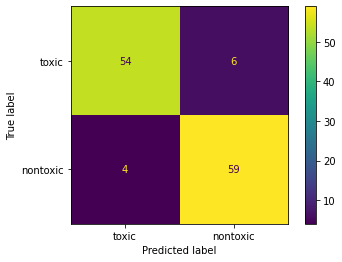

In [ ]:
# Predict audio using CNN
predictions_cnn = model_cnn.predict(test_dataset_cnn)

y_pred = np.argmax(predictions_cnn, axis=1)
y_true = [l for _, l in test_dataset_cnn.unbatch().as_numpy_iterator()]

# Print classification report and confusion matrix
print_cr_cm(y_true, y_pred, labels=CLASS_NAMES)

In [ ]:
cnn_df["audio_prediction_toxic_cnn"] = pd.DataFrame(predictions_cnn)[0]
cnn_df.head()

,Filename,audio_prediction_toxic_cnn
0,0_00002,0.993841
1,0_00007,0.000026
2,0_00008,0.000007
3,0_00009,0.366353
4,0_00012,0.998565


## 2.3 Evaluate audio using RF

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        62
           1       0.81      0.89      0.84        61

    accuracy                           0.84       123
   macro avg       0.84      0.84      0.84       123
weighted avg       0.84      0.84      0.84       123

-------------------------
Confusion Matrix
-------------------------



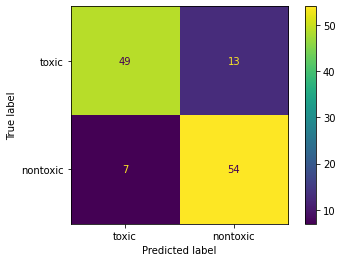

In [ ]:
# Standardize features before predicting
test_dataset_tf_std = StandardScaler().fit_transform(test_dataset_rf)

# 0 = Toxic, 1 = Non-toxic for RF
predictions_rf = model_rf.predict_proba(test_dataset_tf_std)

y_pred = model_rf.predict(test_dataset_tf_std)
y_true = rf_df['label']

# Print classification report and confusion matrix
print_cr_cm(y_true, y_pred, labels=CLASS_NAMES)

In [ ]:
rf_df['audio_prediction_toxic_rf'] = pd.DataFrame(predictions_rf)[[0]]
rf_df.head()

,Filename,label,audio_prediction_toxic_rf
0,0_00009,1,0.774667
1,0_00152,1,0.404667
2,1_00068,0,0.938000
3,0_00190,1,0.205333
4,0_00187,1,0.242000


# 3. Weighted Models

In [ ]:
final_df = pd.merge(text_df, cnn_df, on="Filename")
final_df = pd.merge(final_df, rf_df, on='Filename')
final_df.head()

,Filename,Text,Label,text_prediction_toxic,audio_prediction_toxic_cnn,label,audio_prediction_toxic_rf
0,1_00002,Why do hindus look smelly.,1,0.527486,0.999995,0,0.424667
1,1_00007,"Christians are subhumans with zero intellect, ...",1,0.230780,0.999751,0,0.828000
2,1_00008,A hindu believes a cow to be their mother if s...,1,0.507827,0.999961,0,0.777333
3,1_00009,I dont want to forge friendships with homos no...,1,0.008547,0.975328,0,0.475333
4,1_00012,So basically the Evangelicals are the taliban ...,1,0.023417,0.999991,0,0.868667


In [ ]:
def predict_weighted_label(df, audio_confidence_cnn, audio_confidence_rf, tt_cnn, tt_rf):
  df_ret = df[['Filename', 'Text', 'Label']].copy()
  df_ret['Weighted_cnn'] = df['audio_prediction_toxic_cnn'] * audio_confidence_cnn + df['text_prediction_toxic'] * (1 - audio_confidence_cnn)
  df_ret['Weighted_rf'] = df['audio_prediction_toxic_rf'] * audio_confidence_rf + df['text_prediction_toxic'] * (1 - audio_confidence_rf)

  df_ret['Predicted_cnn'] = df_ret['Weighted_cnn'] > tt_cnn
  df_ret['Predicted_rf'] = df_ret['Weighted_rf'] > tt_rf

  df_ret['Predicted_cnn'] = df_ret['Predicted_cnn'].astype(int)
  df_ret['Predicted_rf'] = df_ret['Predicted_rf'].astype(int)

  return df_ret, df_ret[['Predicted_cnn']], df_ret[['Predicted_rf']]

In [ ]:
AUDIO_CONFIDENCE_CNN = 0.55
AUDIO_CONFIDENCE_RF = 0.54

toxic_thresholds = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
classification_reports = {}

for tt in toxic_thresholds:
    df, c, r = predict_weighted_label(final_df, AUDIO_CONFIDENCE_CNN, AUDIO_CONFIDENCE_RF, tt_cnn = tt, tt_rf = tt)
    cr_c = classification_report(df['Label'], c, target_names=CLASS_NAMES)
    cr_r = classification_report(df['Label'], r, target_names=CLASS_NAMES)
    classification_reports[tt] = {'cnn': cr_c, 'rf': cr_r}

In [ ]:
# Print all classification reports for Text (RNN) and Audio (CNN)
for tt, cr in classification_reports.items():
  print('-' * 52, '\nClassification report for toxic threshold: {} (CNN)\n'.format(tt), '-' * 52, sep = '')
  print()
  print(cr['cnn'])

----------------------------------------------------
Classification report for toxic threshold: 0.2 (CNN)
----------------------------------------------------

              precision    recall  f1-score   support

       toxic       0.91      0.83      0.87        63
    nontoxic       0.83      0.92      0.87        60

    accuracy                           0.87       123
   macro avg       0.87      0.87      0.87       123
weighted avg       0.87      0.87      0.87       123

----------------------------------------------------
Classification report for toxic threshold: 0.25 (CNN)
----------------------------------------------------

              precision    recall  f1-score   support

       toxic       0.92      0.87      0.89        63
    nontoxic       0.87      0.92      0.89        60

    accuracy                           0.89       123
   macro avg       0.89      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123

-------------------------

In [ ]:
# Print all classification reports for Text (RNN) and Audio (RF)
for tt, cr in classification_reports.items():
  print('-' * 51, '\nClassification report for toxic threshold: {} (RF)\n'.format(tt), '-' * 51, sep = '')
  print(cr['rf'])

---------------------------------------------------
Classification report for toxic threshold: 0.2 (RF)
---------------------------------------------------
              precision    recall  f1-score   support

       toxic       0.93      0.65      0.77        63
    nontoxic       0.72      0.95      0.82        60

    accuracy                           0.80       123
   macro avg       0.83      0.80      0.79       123
weighted avg       0.83      0.80      0.79       123

---------------------------------------------------
Classification report for toxic threshold: 0.25 (RF)
---------------------------------------------------
              precision    recall  f1-score   support

       toxic       0.91      0.83      0.87        63
    nontoxic       0.83      0.92      0.87        60

    accuracy                           0.87       123
   macro avg       0.87      0.87      0.87       123
weighted avg       0.87      0.87      0.87       123

---------------------------------

In [ ]:
TT_CNN = 0.5
TT_RF = 0.25

final, _, _ = predict_weighted_label(final_df, AUDIO_CONFIDENCE_CNN, AUDIO_CONFIDENCE_RF, TT_CNN, TT_RF)

y_true = final['Label']
y_pred_cnn = final['Predicted_cnn']
y_pred_rf = final['Predicted_rf']

final.head()

,Filename,Text,Label,Weighted_cnn,Weighted_rf,Predicted_cnn,Predicted_rf
0,1_00002,Why do hindus look smelly.,1,0.787366,0.471963,1,1
1,1_00007,"Christians are subhumans with zero intellect, ...",1,0.653714,0.553279,1,1
2,1_00008,A hindu believes a cow to be their mother if s...,1,0.778501,0.653360,1,1
3,1_00009,I dont want to forge friendships with homos no...,1,0.540277,0.260612,1,1
4,1_00012,So basically the Evangelicals are the taliban ...,1,0.560533,0.479852,1,1


Classification report and metrics for LSTM-RNN (text) and CNN (audio) weighted model:

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        63
           1       0.95      0.90      0.92        60

    accuracy                           0.93       123
   macro avg       0.93      0.93      0.93       123
weighted avg       0.93      0.93      0.93       123

-------------------------
Confusion Matrix
-------------------------



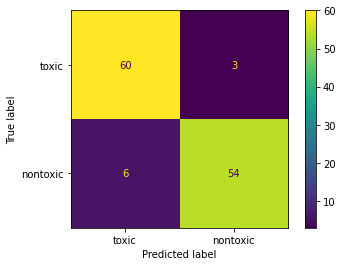

In [ ]:
print_cr_cm(y_true, y_pred_cnn, labels=CLASS_NAMES)

Classification report and metrics for LSTM-RNN (text) and Random Forest (audio) weighted model:

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        63
           1       0.83      0.92      0.87        60

    accuracy                           0.87       123
   macro avg       0.87      0.87      0.87       123
weighted avg       0.87      0.87      0.87       123

-------------------------
Confusion Matrix
-------------------------



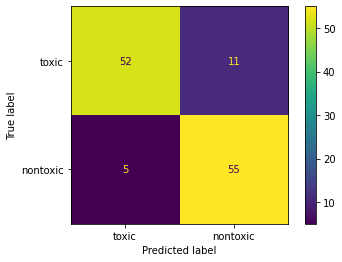

In [ ]:
print_cr_cm(y_true, y_pred_rf, labels=CLASS_NAMES)